In [ ]:
#from google.colab import files
#uploaded = files.upload()

Saving amazon_reviews_test.csv to amazon_reviews_test.csv
Saving amazon_reviews_train.csv to amazon_reviews_train.csv


In [ ]:
import pandas as pd

df_train = pd.read_csv('amazon_reviews_train.csv')
df_test = pd.read_csv('amazon_reviews_test.csv')


### MODELOS PRÉ-TREINADOS COM TRANSFORMERS

In [ ]:
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import evaluate
import torch
import torch
from torch.nn.functional import softmax
from tqdm import tqdm
from datasets import Dataset

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
reviews = df_train['review'].tolist()

# Carregar modelo base
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()

# Função para prever estrelas
def predict_star_rating(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = softmax(outputs.logits, dim=1)
    stars = torch.argmax(probs, dim=1).item() + 1
    return stars

# Aplicar a função
tqdm.pandas()
df_train['stars'] = df_train['review'].progress_apply(predict_star_rating)
df_train['label'] = df_train['stars'].apply(lambda x: 1 if x >= 3 else 0)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

100%|██████████| 48902/48902 [3:22:00<00:00,  4.03it/s]


In [ ]:
train_df, test_df = train_test_split(df_train, test_size=0.2, random_state=42, stratify=df_train["label"])

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "test": Dataset.from_pandas(test_df)
})

In [ ]:
model_checkpoint = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# Tokenizar
def tokenize_function(example):
    return tokenizer(example["review"], truncation=True, padding="max_length", max_length=128)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(["review"])
tokenized_dataset.set_format("torch")


Map:   0%|          | 0/39121 [00:00<?, ? examples/s]

Map:   0%|          | 0/9781 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from transformers import EarlyStoppingCallback

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    ignore_mismatched_sizes=True
)
model = model.to(device)

# Congelar tudo exceto o classificador
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

# Métricas
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels)["f1"]
    }

# Parâmetros de treino
training_args = TrainingArguments(
    output_dir="./results-nlptown-finetuned",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    fp16=True,  # treino em float16 se disponível
    logging_dir="./logs",
    logging_steps=50,
    seed=42,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
early_stopping = EarlyStoppingCallback(early_stopping_patience=2)  # para se não melhorar em 2 épocas

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)


In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.113300,0.117150,0.953583,0.969423
2,0.155900,0.115120,0.956242,0.971279
3,0.095200,0.115395,0.956548,0.971432
4,0.115800,0.113556,0.957775,0.972295
5,0.119100,0.113408,0.957571,0.972157
6,0.110700,0.113536,0.957571,0.972131


TrainOutput(global_step=29346, training_loss=0.13312616424148477, metrics={'train_runtime': 783.9581, 'train_samples_per_second': 499.019, 'train_steps_per_second': 62.389, 'total_flos': 1.543975139510784e+16, 'train_loss': 0.13312616424148477, 'epoch': 6.0})

              precision    recall  f1-score   support

           0     0.9182    0.9045    0.9113      2345
           1     0.9700    0.9746    0.9723      7436

    accuracy                         0.9578      9781
   macro avg     0.9441    0.9395    0.9418      9781
weighted avg     0.9576    0.9578    0.9577      9781



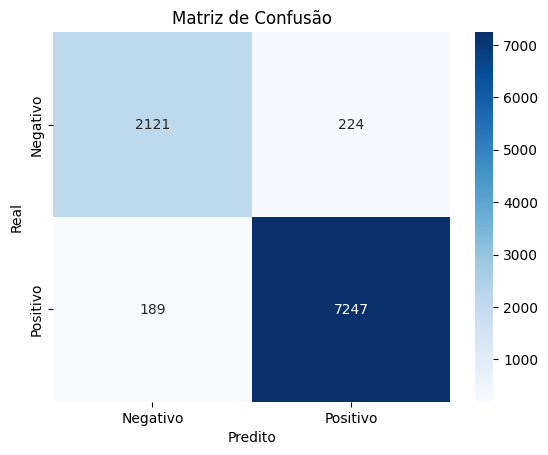

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np

# Pega os dados de teste
test_dataset = tokenized_dataset["test"]

# Faz previsões
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Relatório detalhado
print(classification_report(y_true, y_pred, digits=4))

# Matriz de confusão
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel("Predito")
plt.ylabel("Real")
plt.title("Matriz de Confusão")
plt.show()

In [ ]:
# Acessar métricas após o treino
metrics = trainer.state.log_history

# Visualizar parte das métricas
for entry in metrics:
    if "eval_accuracy" in entry:
        print(entry)

{'eval_loss': 0.11715023219585419, 'eval_accuracy': 0.9535834781719661, 'eval_f1': 0.9694234913793104, 'eval_runtime': 20.8222, 'eval_samples_per_second': 469.739, 'eval_steps_per_second': 58.735, 'epoch': 1.0, 'step': 4891}
{'eval_loss': 0.11511960625648499, 'eval_accuracy': 0.9562416930784173, 'eval_f1': 0.9712790229499396, 'eval_runtime': 20.8467, 'eval_samples_per_second': 469.186, 'eval_steps_per_second': 58.666, 'epoch': 2.0, 'step': 9782}
{'eval_loss': 0.11539456248283386, 'eval_accuracy': 0.9565484101830078, 'eval_f1': 0.9714324124487463, 'eval_runtime': 20.6216, 'eval_samples_per_second': 474.308, 'eval_steps_per_second': 59.307, 'epoch': 3.0, 'step': 14673}
{'eval_loss': 0.1135556548833847, 'eval_accuracy': 0.95777527860137, 'eval_f1': 0.9722948950157644, 'eval_runtime': 20.287, 'eval_samples_per_second': 482.131, 'eval_steps_per_second': 60.285, 'epoch': 4.0, 'step': 19564}
{'eval_loss': 0.11340782791376114, 'eval_accuracy': 0.957570800531643, 'eval_f1': 0.9721569942972157, 